## Prerequisites

In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4

In [ ]:
!ln -s <YOUR-PATH-TO-DATASET> data

In [1]:
import os
import argparse
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from dataset import TrainDataset
from config import cfg

from pprint import pprint
from torch.utils.data import DataLoader

from torchvision.ops import sigmoid_focal_loss, focal_loss

## Load Parameters

In [2]:
cfg.merge_from_file("config/params_hypersim.yaml")

## Dataset

In [3]:
train_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_train,
    cfg.DATASET)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.batch_size,  # we have modified data_parallel
    shuffle=True,  # we do not use this param
    num_workers=cfg.TRAIN.workers,
    drop_last=True,
    pin_memory=True)

valid_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_val,
    cfg.DATASET)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg.VAL.batch_size,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    num_workers=cfg.VAL.workers,
    drop_last=False,
    pin_memory=True)

test_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_test,
    cfg.DATASET)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=cfg.TEST.batch_size,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    num_workers=cfg.TEST.workers,
    drop_last=False,
    pin_memory=True)

# samples: 4042
# samples: 198
# samples: 500


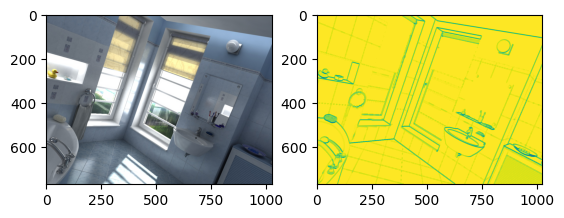

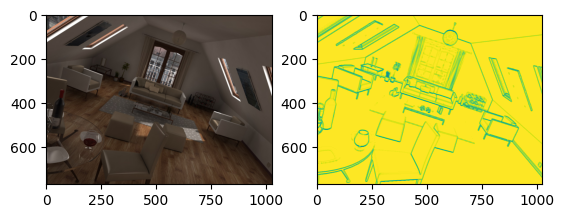

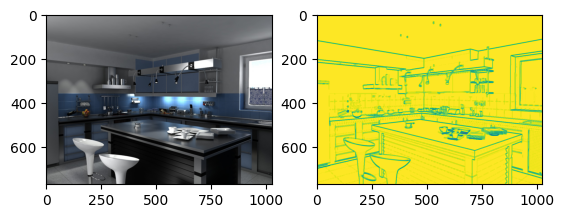

In [4]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow((sample["mask"].squeeze()+1)/2)  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow((sample["mask"].squeeze()+1)/2)  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow((sample["mask"].squeeze()+1)/2)  # for visualization we have to remove 3rd dimension of mask
plt.show()

## Model

In [5]:
def WMSELoss(input, target, weight=2.0):
    mask = torch.abs(input) > 1.0
    sqr = (input - target) ** 2
    return torch.mean(sqr*(weight * mask + ~mask))

class StructurenessModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn = torch.nn.BCELoss()
        # self.loss_fn = torch.nn.MSELoss()
        # self.loss_fn = WMSELoss
        # self.loss_fn = sigmoid_focal_loss

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32);
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes (1), height, width]
        assert mask.ndim == 4

        # Check that mask values in between -1 and 1
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)

        prob_mask = logits_mask.sigmoid()
        loss = self.loss_fn(prob_mask, (mask+1)/2)
        # loss = self.loss_fn(prob_mask, mask.abs())
        # loss = self.loss_fn(prob_mask, torch.clip(mask, min=0))
        # loss = self.loss_fn(prob_mask, (mask <= np.pi/4).float())

        # prob_mask = logits_mask.tanh()

        # loss = self.loss_fn(logits_mask, (mask+1)/2, reduction='mean')
        # loss = self.loss_fn(logits_mask, mask.abs(), reduction='mean')
        # loss = self.loss_fn(logits_mask, torch.clip(mask, min=0), reduction='mean')
        # loss = self.loss_fn(logits_mask, (mask <= np.pi/4).float(), reduction='mean')

        return {
            "loss": loss,
        }

    def shared_epoch_end(self, outputs, stage):

        metrics = {
            f"{stage}_loss_epoch": torch.mean(torch.tensor([x["loss"] for x in outputs]))
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "train") 
        self.log(f"train_loss", loss["loss"])
        return loss

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "valid") 
        self.log(f"valid_loss", loss["loss"])
        return loss

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)

        prob_mask = logits_mask.sigmoid()
        
        # loss = self.loss_fn(prob_mask, mask.abs())
        loss = self.loss_fn(prob_mask, (mask+1)/2)
        # loss = self.loss_fn(prob_mask, torch.clip(mask, min=0))
        # loss = self.loss_fn(prob_mask, (mask <= np.pi/4).float())

        # loss = self.loss_fn(logits_mask, mask.abs(), reduction='mean')
        # loss = self.loss_fn(logits_mask, torch.clip(mask, min=0), reduction='mean')
        # loss = self.loss_fn(logits_mask, (mask+1)/2, reduction='mean')
        # loss = self.loss_fn(logits_mask, (mask <= np.pi/4).float(), reduction='mean')

        # prob_mask = logits_mask.tanh()

        # loss = self.loss_fn(prob_mask, mask)

        # Save predicted normal difference
        prob_mask = prob_mask.squeeze(1)
        # logits_mask = logits_mask.squeeze(1)
        for i, savedir in enumerate(batch["savedir"]):
            dir = os.path.join(*savedir.split('/')[:-1])
            if not os.path.exists(dir):
                os.makedirs(dir)
            mask = torch.flip(prob_mask[i], [1]) if batch['flipped'][i] else prob_mask[i]
            # np.savez_compressed(savedir, normals_diff=(2*mask-1).cpu().numpy())
            np.savez_compressed(savedir, normals_diff=mask.cpu().numpy())
            # np.savez_compressed(savedir, normals_diff=torch.clamp(mask, min=-1, max=1).cpu().numpy())

        return {
            "loss": loss.item(),
        }

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

### Train From Scratch Model

In [6]:
model = StructurenessModel(cfg.MODEL.arch_decoder, cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=15,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FPN  | 23.2 M
-------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


A Jupyter Widget

/home/sinjeong/anaconda3/envs/dl-pjt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


A Jupyter Widget

A Jupyter Widget

/home/sinjeong/anaconda3/envs/dl-pjt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

### Work with Pretrained Model

In [13]:
# model = StructurenessModel.load_from_checkpoint("epoch=29-step=15149.ckpt", arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)
# model = StructurenessModel.load_from_checkpoint("lightning_logs/version_17/checkpoints/epoch=17-step=9089.ckpt", arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)
# model = StructurenessModel.load_from_checkpoint("lightning_logs/version_6/checkpoints/epoch=14-step=10094.ckpt", arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)
model = StructurenessModel.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=14-step=7574.ckpt", arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)
# model = StructurenessModel.load_from_checkpoint("abs_sigmoid_24e.ckpt", arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=0,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Validation and test metrics

In [6]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

/home/sinjeong/anaconda3/envs/dl-pjt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[{'valid_loss': 0.07930358499288559, 'valid_loss_epoch': 0.07931295037269592}]


/home/sinjeong/anaconda3/envs/dl-pjt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


In [12]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

# test_metrics = trainer.test(model, dataloaders=train_dataloader, verbose=False)
# pprint(test_metrics)

# test_metrics = trainer.test(model, dataloaders=valid_dataloader, verbose=False)
# pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

[{'test_loss_epoch': 0.016857627779245377}]


# Result visualization

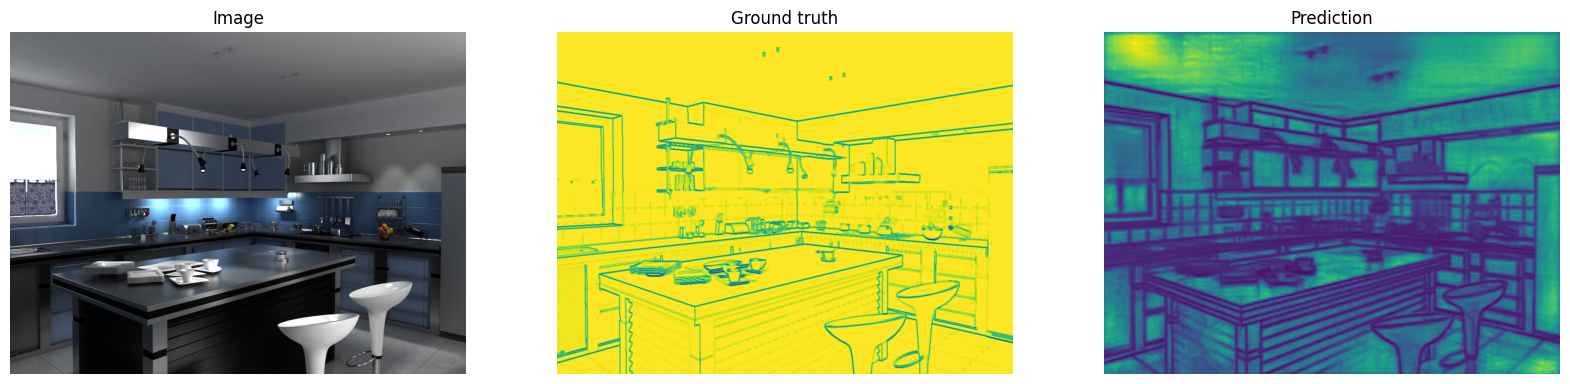

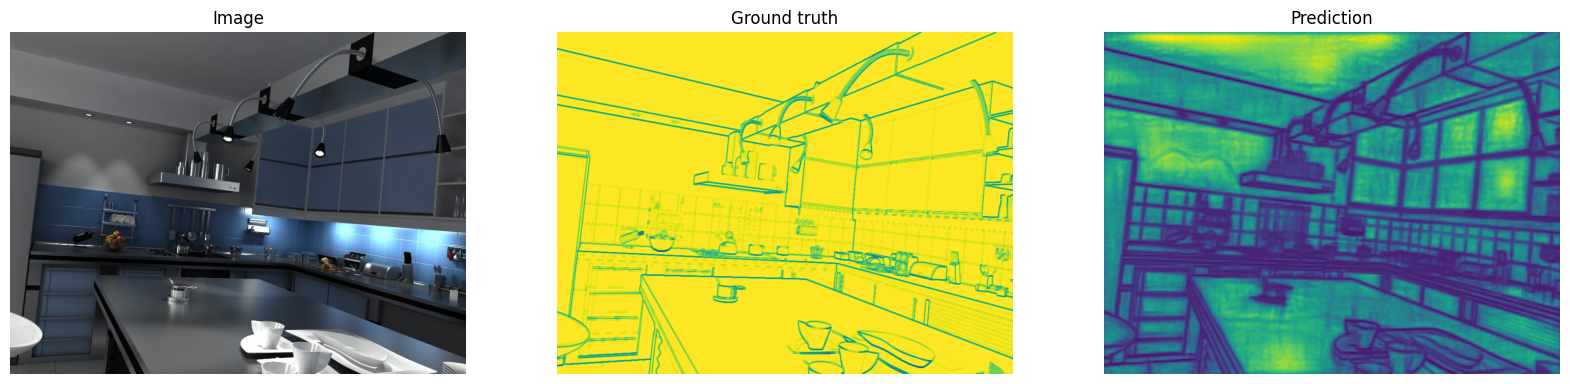

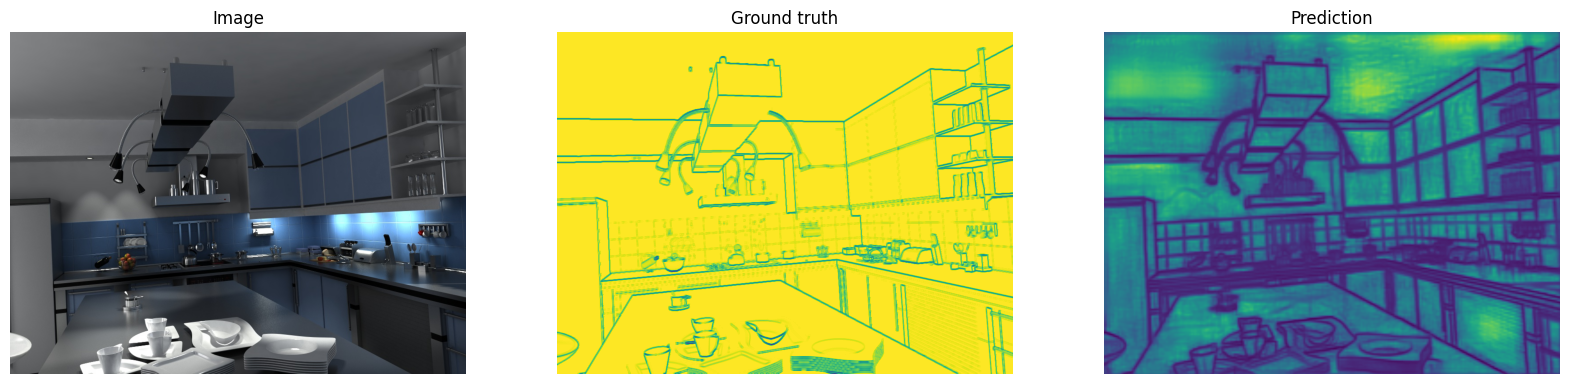

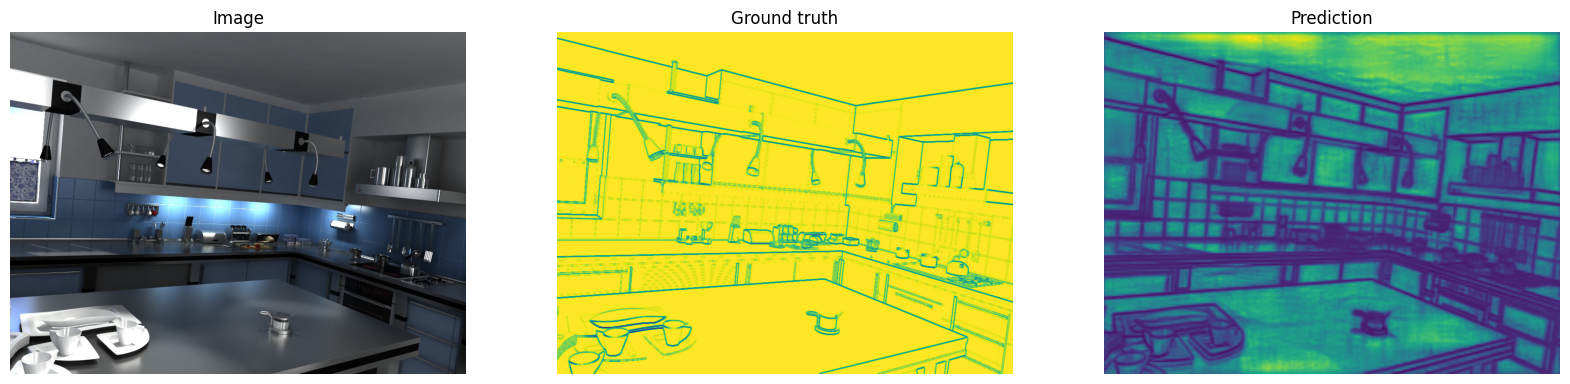

In [7]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
# pr_masks = logits.sigmoid()
pr_masks = logits

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow((gt_mask.numpy().squeeze()+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow((pr_mask.numpy().squeeze()+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

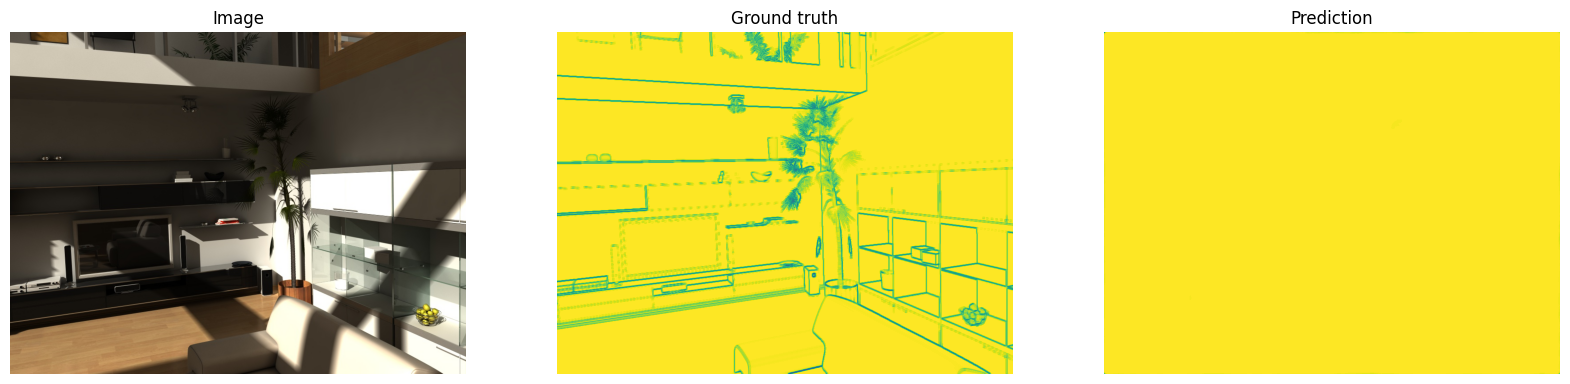

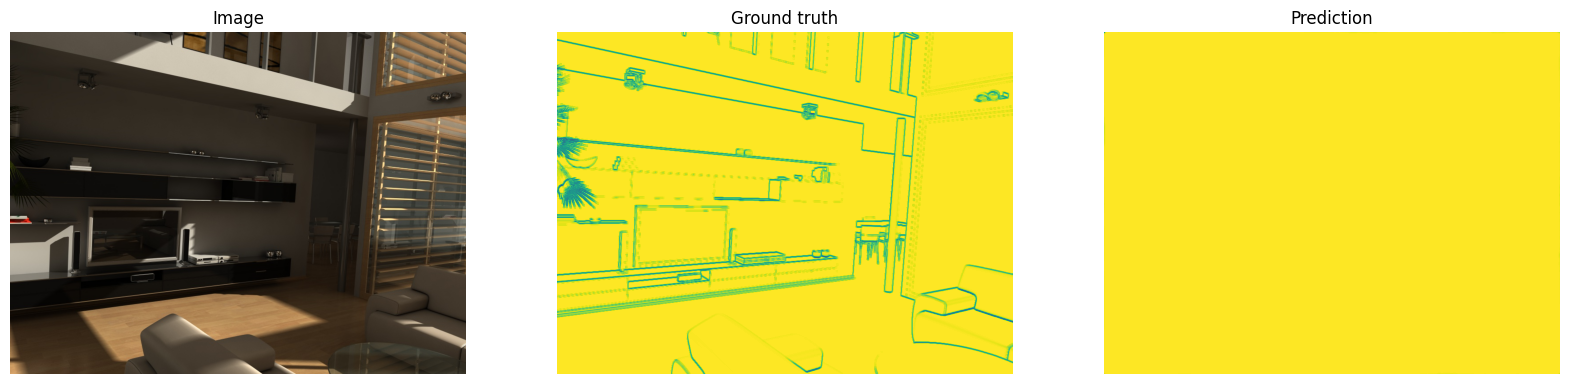

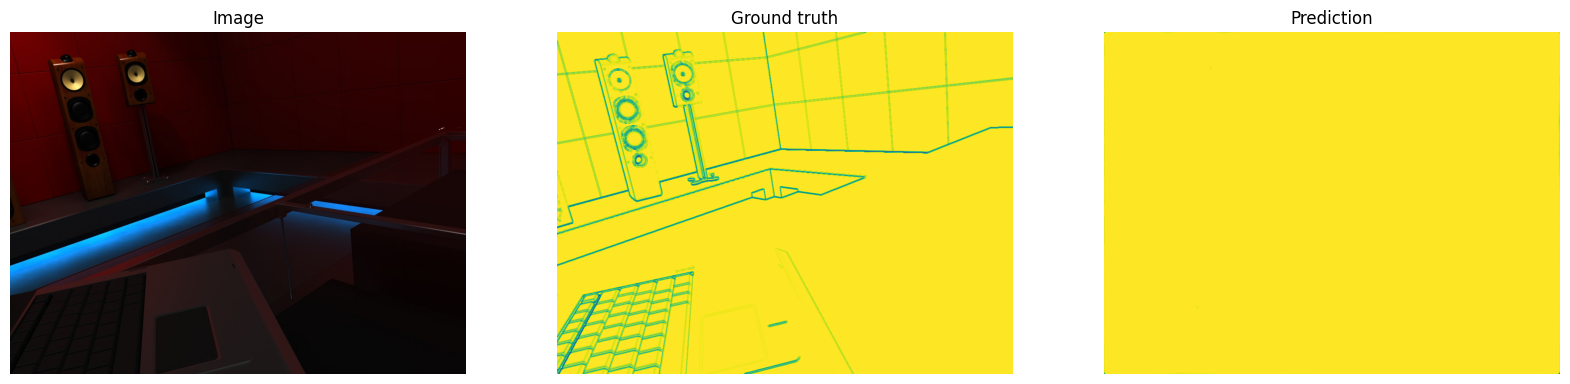

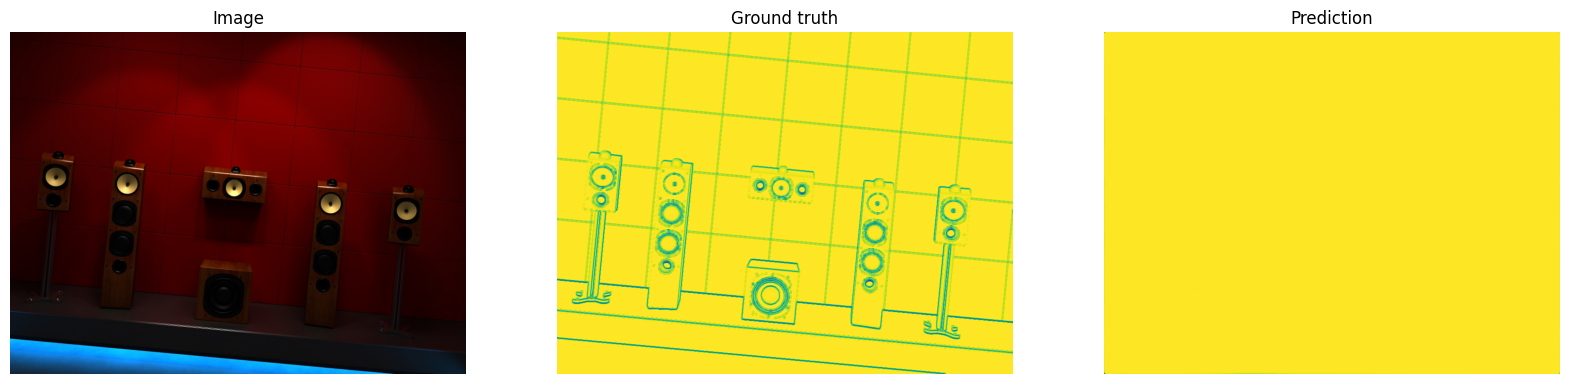

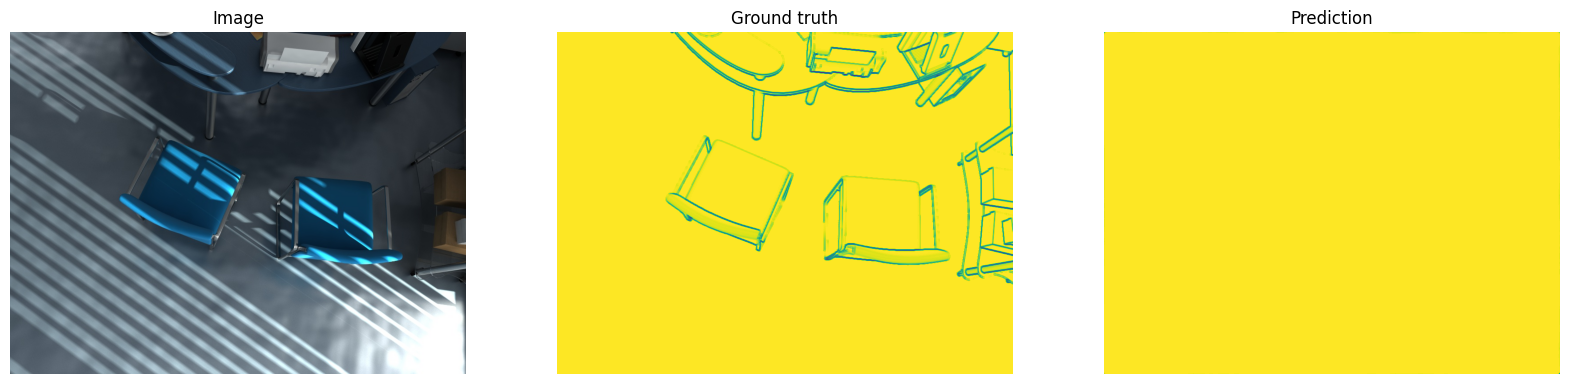

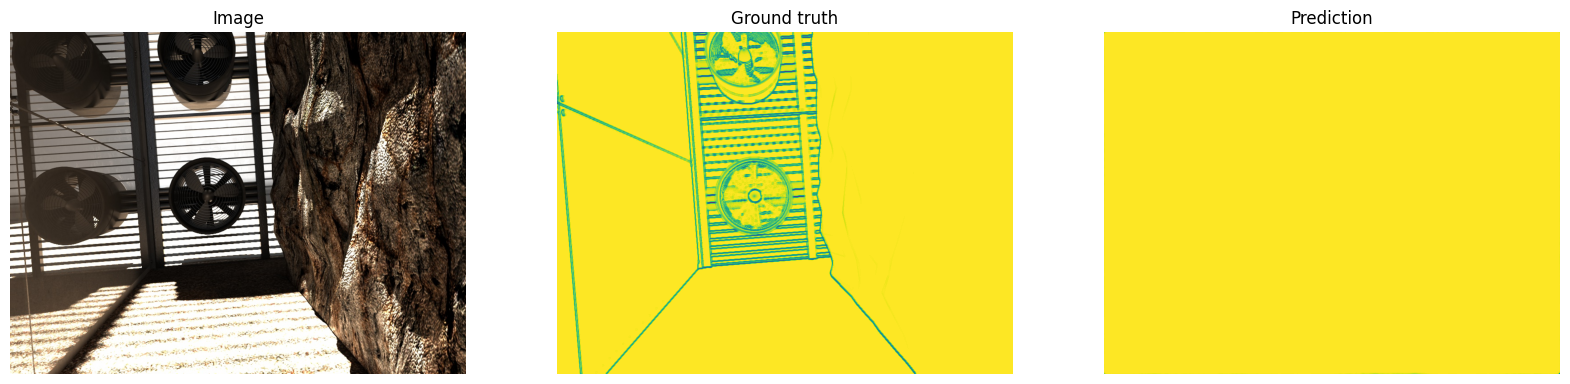

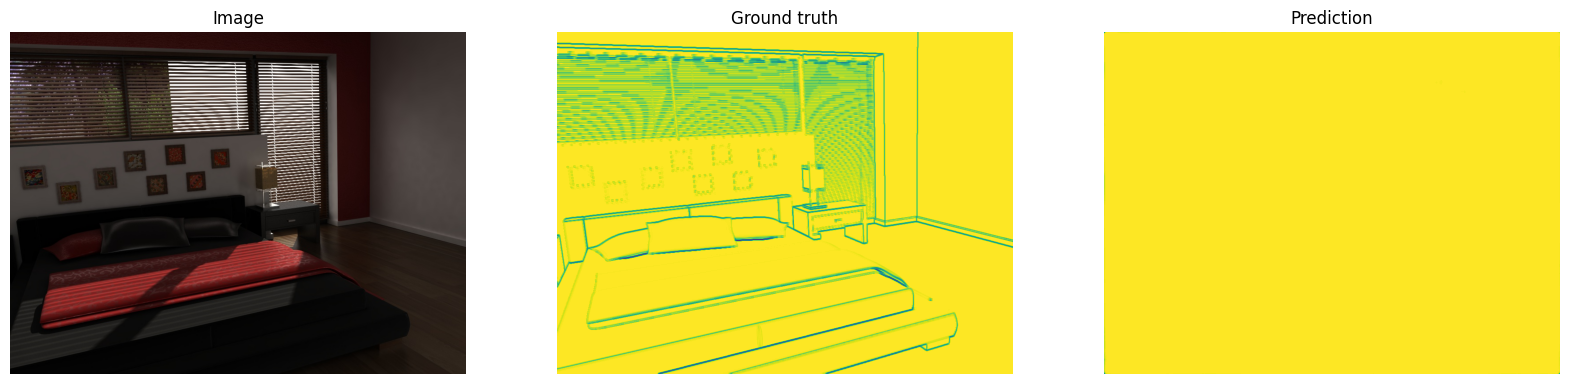

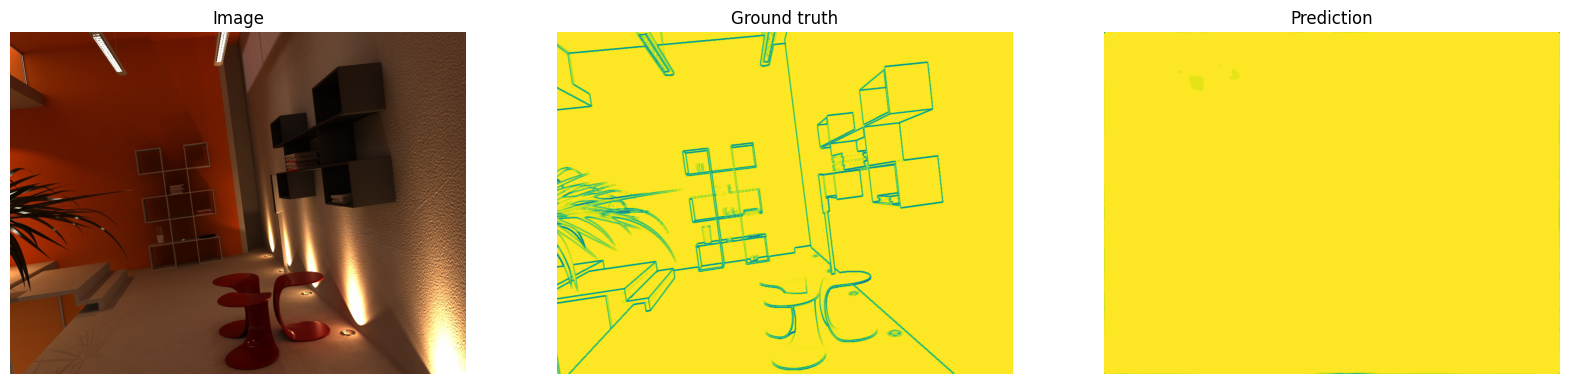

In [11]:
batch = next(iter(train_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow((gt_mask.numpy().squeeze()+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()